# Food Detection


In [1]:
import tensorflow as tf
print("Tensorflow Version: {}".format(tf.__version__))
# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())


Tensorflow Version: 2.7.0
The following GPU devices are available: /device:GPU:0


## Setup


In [10]:

try:
    import tensorflow_hub as hub
    import tensorflow as tf
    
    module_handle = "D:/pythonwork/Eating_health_management/faster_rcnn_openimages_v4_inception_resnet_v2_1"
    ResNet_V2_50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'
    Seg_Unet_model = "./Seg_model/oxford_segmentation_fix_v10.h5"
    
    #obj detection
    print("Loading {} Model...".format(module_handle.split("/")[-1]))
    detector = hub.load(module_handle).signatures['default']
    print("Load {} Model Successfully".format(module_handle.split("/")[-1]))

    #classificaiton
    print("Loading {} Model...".format(ResNet_V2_50.split("/")[-3]))
    model_ResNet = tf.keras.Sequential([
    hub.KerasLayer(ResNet_V2_50, trainable = False, input_shape = (250,250,3), name = 'Resnet_V2_50'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(101, activation = 'softmax', name = 'Output_layer')
    ])
    model_ResNet.load_weights("./best_model/20220117-032102_Resnet_V2_50_best_weight.hdf5")
    print("Load {} Model Successfully".format(ResNet_V2_50.split("/")[-3]))
    
    #load Seg model
    print("Loading {} Model...".format(Seg_Unet_model.split("/")[-1]))
    seg_model = tf.keras.models.load_model(Seg_Unet_model)
    print("Load {} Model Successfully".format(Seg_Unet_model.split("/")[-1]))
    
    
except:
    print("Load Model Failed")



Loading faster_rcnn_openimages_v4_inception_resnet_v2_1 Model...
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Load faster_rcnn_openimages_v4_inception_resnet_v2_1 Model Successfully
Loading resnet_v2_50 Model...
Load resnet_v2_50 Model Successfully
Loading oxford_segmentation_fix_v10.h5 Model...
Load oxford_segmentation_fix_v10.h5 Model Successfully


Tensorflow Version: 2.7.0
The following GPU devices are available: /device:GPU:0
Inference No.1 Food Image
Found 100 objects.
Inference time:  1.3022446632385254
Font not found, using default font.


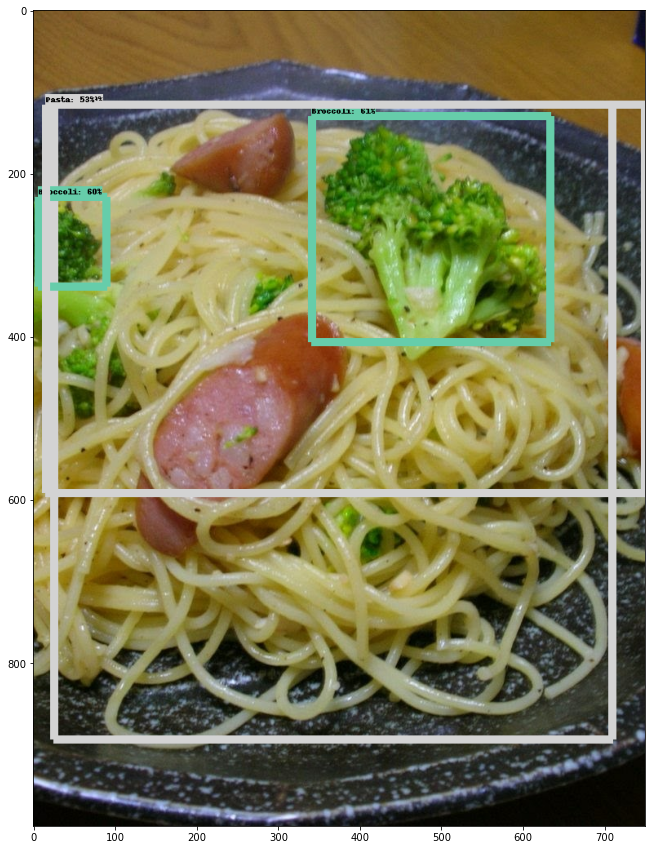

obj_image: (777, 685, 3)


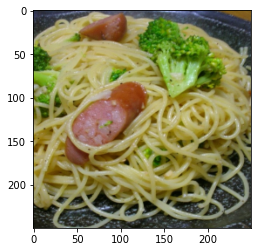

obj_image: (276, 293, 3)


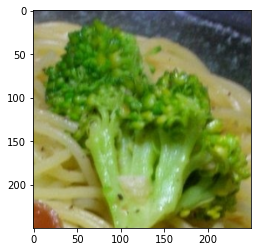

obj_image: (109, 84, 3)


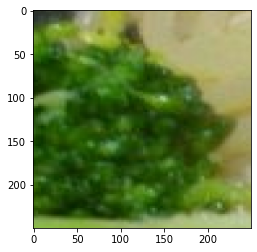

obj_image: (475, 735, 3)


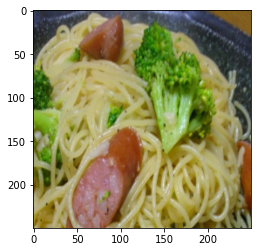

TypeError: Cannot handle this data type: (1, 1, 104), <f4

In [86]:
import tensorflow as tf
import tensorflow_hub as hub
# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import cv2
import pandas as pd

# For measuring the inference time.
import time

# Print Tensorflow version
print("Tensorflow Version: {}".format(tf.__version__))
# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

color_list = np.array(
    [ [210, 55, 55],  
     [210, 210, 55],
     [55, 210, 55],
     [55, 210, 210],
     [55, 55, 210],
     [171, 55, 210],
     [210, 55, 133],
    ] )
color_index=["紅色", "黃色", "綠色", "天空色", "藍色", "紫色", "粉紅色"]

## Example use

### Helper functions for downloading images and for visualization.

#Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=10,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.5):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

## Apply module

#Load a public image from Open Images v4, save locally, and display.

#Pick an object detection module and apply on the downloaded image. Modules:
#* **FasterRCNN+InceptionResNet V2**: high accuracy,
#* **ssd+mobilenet V2**: small and fast.


def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)
  return result

def crop_roi_food(path,res,index,conf=.5):
    if res["detection_scores"][index] >= conf:
        ymin, xmin, ymax, xmax = tuple(res["detection_boxes"][index])
        img = load_img(path)
        im_width = img.shape[1]
        im_height = img.shape[0]
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                    ymin * im_height, ymax * im_height)
        obj_image = img[int(top):int(bottom),int(left):int(right)]
        obj_image = np.array(obj_image)
        print("obj_image:",obj_image.shape)
        obj_image = cv2.resize(obj_image, (250, 250), interpolation=cv2.INTER_AREA)
        
        plt.imshow(obj_image)
        plt.show()
        return  obj_image

def food_seg(index,image):
    
    image = cv2.resize(image, (160, 160), interpolation=cv2.INTER_AREA)
    image_expend = np.expand_dims(image,0)
    pred = seg_model.predict(image_expend)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite('output_{}.jpg'.format(index), rgb)
    pred_img = Image.fromarray(np.array(pred[0]))
    pred_img.save('test_img.jpg')
    
    return pred

def color_mask(path):
    img_a = cv2.imread(path)
    img_a = cv2.resize(img_a, (160,160) )
    rgb = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
    rgb_test = rgb
    print(rgb.shape)
    
    img = load_img("test_0_ann.png", target_size=(160,160), color_mode="grayscale")
    label = np.unique(np.array(img))
    print(label)
    
    color_index = 0;
    for z in label:
        if z ==0:
            continue
        rgb_test[:,:,0] = np.where(rgb[:,:,0]==z, color_list[color_index][0], rgb[:,:,0])
        rgb_test[:,:,1] = np.where(rgb[:,:,1]==z, color_list[color_index][1], rgb[:,:,1])
        rgb_test[:,:,2] = np.where(rgb[:,:,2]==z, color_list[color_index][2], rgb[:,:,2])
        color_index+=1
         
        
    rgb_test = Image.fromarray(rgb_test)

    rgb_test.save('rgb_test.jpg')
    plt.imshow(rgb_test)
    return color_index

def color_mask_pred(path, path_real):
    img_a = cv2.imread(path)
    img_a = cv2.resize(img_a, (160,160) )
    rgb = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
    rgb_test = rgb
    print(rgb.shape)
    img = load_img(path_real, target_size = (160,160))
    label = np.unique(np.array(img))
    print(label)
    
    color_index = 0;
    for z in label:
        if z ==0:
            continue
        rgb_test[:,:,0] = np.where(rgb[:,:,0]==z, color_list[color_index][0], rgb[:,:,0])
        rgb_test[:,:,1] = np.where(rgb[:,:,1]==z, color_list[color_index][1], rgb[:,:,1])
        rgb_test[:,:,2] = np.where(rgb[:,:,2]==z, color_list[color_index][2], rgb[:,:,2])
        color_index+=1
        

    
    rgb_test = Image.fromarray(rgb_test)

    rgb_test.save('rgb_test_pred.jpg')
    plt.imshow(rgb_test)
    return color_index

def color_show(path_a, path_b):   
    img_a = cv2.imread(path_a)
    img_a = cv2.resize(img_a, (160,160) )
    img_b = cv2.imread(path_b)
    img_b = cv2.resize(img_b, (160,160) )
    # cv2.waitKey(0)
    # cv2.imshow('mg_A',img_a)
    # cv2.destroyAllWindows()

    dst = cv2.addWeighted(img_a, 0.9, img_b, 0.5, 5.0)
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    img_b=cv2.cvtColor(img_b,cv2.COLOR_BGR2RGB)
    img_a=cv2.cvtColor(img_a,cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, 1)
    plt.title('pred')
    plt.imshow(gray)
    plt.subplot(2, 3, 2)
    plt.title('img')
    plt.imshow(img_b)
    plt.subplot(2, 3, 3)
    plt.title('mask')
    plt.imshow(img_a) 
    

if __name__=="__main__":
    
    import glob
    import pandas as pd
    #test_list = glob.glob("./test_img/*.jpg")
    test_list= ["./00006784.jpg"]
    """
    try:
        module_handle = "D:/pythonwork/Eating_health_management/faster_rcnn_openimages_v4_inception_resnet_v2_1"
        print("Loading {} Model...".format(module_handle.split("/")[-1]))
        detector = hub.load(module_handle).signatures['default']
        print("Load Model Successfully")


    except:
        print("Load Model Failed")

    """
    class_df = pd.read_csv("dict.csv")
    while True:
        
        if len(test_list) == 0:
            
            print("Waiting...")
       
        else:
            for i,path in enumerate(test_list[:]):
                obj_list = []
                print("Inference No.{} Food Image".format(i+1))
                res = run_detector(detector, path)
                plt.show()
                obj_len = res["detection_scores"][res["detection_scores"]>=0.5].shape[0]
                for i in range(obj_len):
                    obj_list.append([crop_roi_food(path,res,i)])
                obj_arr = np.concatenate(obj_list)
                classfi_res = model_ResNet.predict(obj_arr)
                
                for j,obj_image in enumerate(obj_arr):
                    pre_mask = food_seg(j,obj_image)
                
                
                
                
                    
                print(obj_arr.shape)
                for i in range(classfi_res.shape[0]):
                    
                    print(class_df[class_df["value"]==np.argmax(classfi_res[i])]["Class name"].values[0],": ",round(classfi_res[i,np.argmax(classfi_res[i])]*100,3),"%")
                    #print("pasta",": ",round(classfi_res[i,np.argmax(classfi_res[i])]*100,3),"%")
                print("\n")
            test_list = []
            break



In [65]:
image_expend.shape
image_expend_255 = image_expend/255.
image_expend_255.shape

(1, 160, 160, 3)

In [132]:
pred = seg_model.predict(image_expend_255)
np.save('pred_mask.npy', pred)

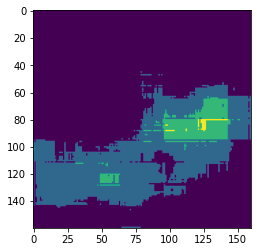

In [162]:
# pred_mask_test = np.where(test_mask > np.percentile(test_mask,50),65,0)
test = np.around(test, decimals=1)
pred_mask_test = test[:,:,65]

plt.imshow(pred_mask_test)

(160, 160, 3)


array([[49.,  0.,  0., ...,  0.,  0., 49.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [65.,  0.,  0., ...,  0.,  0.,  0.],
       [65.,  0.,  0., ...,  0.,  0.,  0.],
       [65.,  0.,  0., ...,  0.,  0., 65.]])

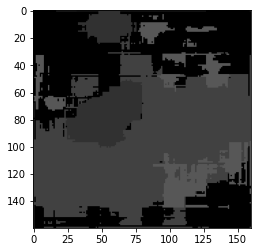

In [116]:
from tensorflow.keras.preprocessing.image import load_img


#load pasta
img_o = load_img("test_0.jpg", target_size=(160,160))
img_o = np.array(img_o)
image_expend = np.expand_dims(img_o,0)
pred = seg_model.predict(image_expend_255)




pred_mask = np.zeros((160,160,3))
test = pred[0]

test_mask = test[:,:,65]
pred_mask_50 = test_mask

pred_mask_50 = np.where(test_mask > np.percentile(test_mask,50),65,0)
pred_mask[:,:,0]=pred_mask_50
pred_mask[:,:,1]=pred_mask_50
pred_mask[:,:,2]=pred_mask_50

test_mask = test[:,:,49]
pred_mask_50 = np.where(test_mask > np.percentile(test_mask,90),49,pred_mask_50)
pred_mask[:,:,0]=pred_mask_50
pred_mask[:,:,1]=pred_mask_50
pred_mask[:,:,2]=pred_mask_50

test_mask = test[:,:,87]
pred_mask_50 = np.where(test_mask > np.percentile(test_mask,90),87,pred_mask_50)
pred_mask[:,:,0]=pred_mask_50
pred_mask[:,:,1]=pred_mask_50
pred_mask[:,:,2]=pred_mask_50

print(pred_mask.shape)
pred_mask_50_img = Image.fromarray(pred_mask.astype('uint8'))
pred_mask_50_img.save("pred_mask_50_img.jpg")
plt.imshow(pred_mask.astype('uint8'))
pred_mask[:,:,0]       

(160, 160, 3)
[ 0 49 65 87]
3


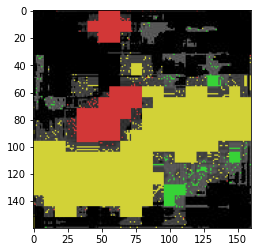

In [118]:
from tensorflow.keras.preprocessing.image import load_img

color_index=color_mask_pred('pred_mask_50_img.jpg',"test_0_ann.png")
print(color_index)

## 真實

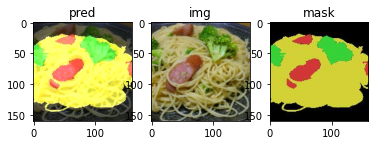

In [119]:
color_show("rgb_test.jpg","test_0.jpg")

## 預測

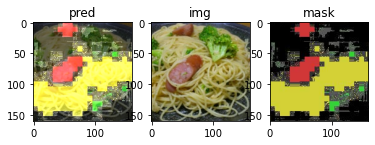

In [120]:
color_show("rgb_test_pred.jpg","test_0.jpg")

In [121]:
color_index=["紅色", "黃色", "綠色", "天空色", "藍色", "紫色", "粉紅色"]
img = load_img("test_0_ann.png", target_size=(160,160), color_mode="grayscale")
img_array = np.array(img)
unique, counts = np.unique(img_array, return_counts=True)
color_label = 0;
for i,j in zip(unique, counts):
    if i ==0:
        print("背景: "+str(j))
        continue
    print(str(color_index[color_label]) +": "+str(j) )
    color_label+=1
print(img_array.shape)

背景: 8868
紅色: 1718
黃色: 12905
綠色: 2109
(160, 160)


In [123]:
color_index=["紅色", "黃色", "綠色", "天空色", "藍色", "紫色", "粉紅色"]
unique, counts = np.unique(pred_mask[:,:,0], return_counts=True)
color_label = 0;
for i,j in zip(unique, counts):
    if i ==0:
        print("背景: "+str(j))
        continue
    print(str(color_index[color_label]) +": "+str(j) )
    color_label+=1
print(img_array.shape)

背景: 9279
紅色: 2558
黃色: 11203
綠色: 2560
(160, 160)
